# Replicate QST article sims

### 1. RSB Hamiltonian Figure 1b

In the Fock mixtures paper, Figure 1b shows the dynamics under the RSB Hamiltonian with dissipation. The full ion trap QHO hamiltonian is:
$$
H = \frac{\Delta}{2}\sigma_{z} + \nu aa^{\dagger} + \frac{\Omega}{2}\big[\sigma^{+}D(i\eta) +\sigma^{-}D^{\dagger}(i\eta) \big]
$$

Where $D(i\eta) = e^{i\eta(a + a^{\dagger})}$ is the displacement operator. In the Lamb-Dicke regime, we can approximate this Hamiltonian to the first red sideband (RSB) interaction:
$$
H' = \frac{i\Omega\eta}{2}\big[\sigma_x(a^{\dagger} + a )\big]
$$


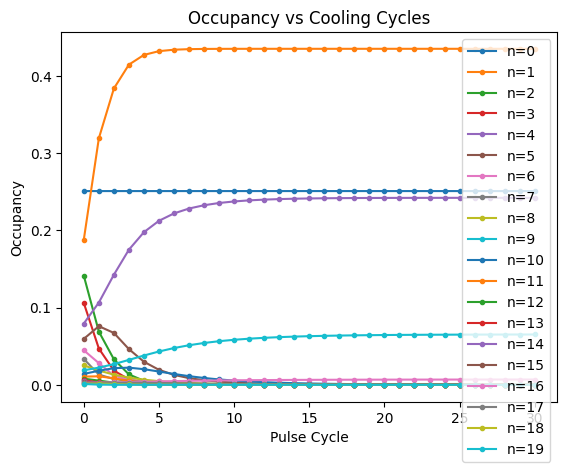

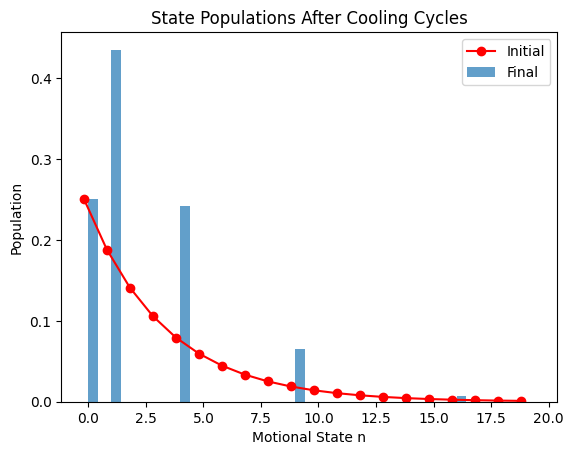

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.02  # Rabi frequency
eta = 0.02    # Lamb-Dicke parameter
n_thermal = 3  # Average thermal phonon number
n0 = 1
gamma = 1000  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration

# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))

# Hamiltonian (Red Sideband for Pulse)
# H_pulse = 1j*eta*Omega/2 * (a_full* s_plus_full - a_dag_full * s_minus_full)
# Displacement operator D(i*eta)
# Note: In the paper, the argument is i*eta.
D_op = tensor(qeye(2), displace(N, 1j * eta))

# RSB Hamiltonian (Figure 1b)
H_pulse = -1j*eta*Omega/2 * (a_full* s_plus_full - a_dag_full * s_minus_full)

# Hamiltonian (Free evolution for Dissipation) - Assuming H0 during dissipation phase? 
# For now, let's assume H_diss = 0 for the dissipative step relative to the rotating frame.
H_diss = Delta*s_z_full/2 + nu*a_dag_full*a_full

# --- Collapse Operators for Dissipation with recoil ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / np.sum(W)
G = gamma / 2  # This is Γ/2 in the master equation
tg = 2 / G  # Dissipation duration adjusted for rates
c_ops = []
for i, c in enumerate(cosal):
    U_mot = (1j * c * eta * xop).expm()
    U_full = tensor(qeye(2), U_mot)
    c_ops.append(np.sqrt(G * W[i]) * (s_minus_full * U_full))

# Add sigma_minus decay without recoil (optional, for comparison)
c_ops.append(np.sqrt(gamma) * s_minus_full)

# --- Construct Liouvillians ---
# 1. Pulse Step: Coherent RSB drive, NO dissipation (or minimal?)
# Typically only Unitary part active during pulse
L_pulse = liouvillian(H_pulse, []) 

# 2. Dissipation Step: No Drive, ONLY Dissipation (Optical Pumping)
# H = 0 (or H0), c_ops active
L_diss = liouvillian(H_diss, c_ops)

# --- Propagators ---
# Propagator for Pulse step (duration tau)
prop_pulse = (L_pulse * tau).expm()

# Propagator for Dissipation step (duration tg)
prop_diss = (L_diss * tg).expm()

# Combined Propagator for one cycle (Pulse -> Dissipation)
prop_cycle = prop_diss * prop_pulse 


# --- Simulation ---
num_pulses = 30 # Number of cycles
times_sim = np.arange(num_pulses + 1) # Just integer steps for cycles

# Initial state
rho_thermal = thermal_dm(N, n_thermal)
p_thermal = rho_thermal.diag()
ground_state = basis(2, 1) 
initial_state = tensor(ground_state * ground_state.dag(), rho_thermal)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec
    
    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial', color='red')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles')
plt.legend()
plt.show()

### 2. Full Hamiltonian (Figures 5 and 6)

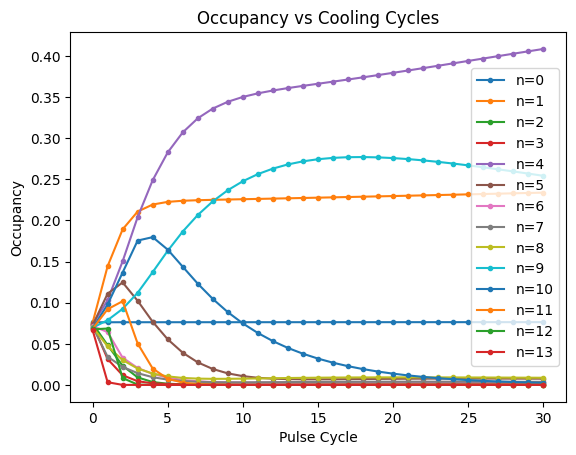

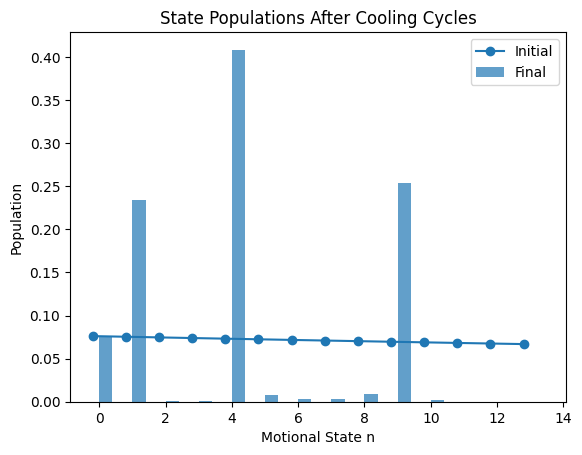

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.0001  # Rabi frequency
eta = 0.05    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 1000  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration

# Define operators
N = 14  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))

# Displaced hamiltonian operator
D_op = tensor(qeye(2), displace(N, 1j * eta))

# Full Hamiltonian (Eq. 1)
# We set detuning Delta = nu to drive the Red Sideband
H_pulse = 0.5 * Delta * s_z_full + nu * a_dag_full * a_full + \
          0.5 * Omega * (s_plus_full * D_op + s_minus_full * D_op.dag())

# Hamiltonian (Free evolution for Dissipation)
H_diss = Delta*s_z_full/2 + nu*a_dag_full*a_full

# The density matrix in the master equation is displaced due to recoil from spontaneous emission.
# We can include this effect in the collapse operators by integrating over the angular distribution of emission
# in a dipolar transition.


# --- Collapse Operators for Dissipation with recoil ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / np.sum(W)
G = gamma / 2  # This is Γ/2 in the master equation
tg = 2 / G  # Dissipation duration adjusted for rates
c_ops = []
for i, c in enumerate(cosal):
    U_mot = (1j * c * eta * xop).expm()
    U_full = tensor(qeye(2), U_mot)
    c_ops.append(np.sqrt(G * W[i]) * (s_minus_full * U_full))

# Add sigma_minus decay without recoil (optional, for comparison)
c_ops.append(np.sqrt(gamma) * s_minus_full)
# --- Construct Liouvillians ---
# 1. Pulse Step: Coherent RSB drive, NO dissipation (or minimal?)
# Typically only Unitary part active during pulse
L_pulse = liouvillian(H_pulse, []) 

# 2. Dissipation Step: No Drive, ONLY Dissipation (Optical Pumping)
# H = 0 (or H0), c_ops active
L_diss = liouvillian(H_diss, c_ops)

# --- Propagators ---
# Propagator for Pulse step (duration tau)
prop_pulse = (L_pulse * tau).expm()

# Propagator for Dissipation step (duration tg)
prop_diss = (L_diss * tg).expm()

# Combined Propagator for one cycle (Pulse -> Dissipation)
prop_cycle = prop_diss * prop_pulse 


# --- Simulation ---
num_pulses = 30 # Number of cycles
times_sim = np.arange(num_pulses + 1) # Just integer steps for cycles

# Initial state
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr() 
ground_state = basis(2, 1) 
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec
    
    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles')
plt.legend()
plt.show()

### 3. New pulse sequence


* RF dipolar pulse to the trapped ion
* Y pulse of pi/2
* x pulse of length $\tau$
* undo y pulse
* Relacation to ground spin state
* undo displacement RF pulse

In this frame, $\Omega = \nu$ and $\Delta = 0$

#### 3.1 Testing each pulse separately
- RF dipolar pulse:
$$
H_{RF} = i\frac{RF\_strength}{2} (a - a^{\dagger})
$$
where $RF\_strength$ is the strength of the RF dipolar coupling, set to $\eta$

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 0  # Detuning
RF_strength = 1  # RF dipolar coupling strength
nu = 1.0     # Motional frequency
Omega = nu  # Rabi frequency
Omega_y = 1*Omega  # Rabi frequency for Y pulse
eta = 0.2    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 1000  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration
print(f"Pulse duration tau: {tau}")
# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag  # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()
s_y = sigmay()
s_x = sigmax()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
s_minus_full = tensor(s_minus, qeye(N))
s_y_full = tensor(s_y, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_x_full = tensor(s_x, qeye(N))

# Displaced Hamiltonian operator
D_op = tensor(qeye(2), displace(N, 1j * eta))

"""Hamiltonians for pulse and dissipation steps defined above."""

# Hamiltonian (Free evolution for Dissipation)
H_diss = Delta * s_z_full / 2 + nu * a_dag_full * a_full

# --- Pulses for the new sequence ---

# 1) RF dipolar pulse of i*eta/2
H_rf = (RF_strength / 2) * (a_full - a_dag_full)
rf_duration = -1j * eta / RF_strength
L_rf = liouvillian(H_rf, [])
prop_rf = (L_rf * rf_duration).expm()
# undo RF
prop_rf_undo = (-L_rf * rf_duration).expm()

# Test the displacement of this pulse on a vacuum motional state
ground_state = basis(2, 1)
initial_state = tensor(ground_state * ground_state.dag(), basis(N, 0) * basis(N, 0).dag())

print("Initial motional state populations:", initial_state.ptrace(1).diag().real)
print("Expected displacement amplitude:", eta / 2)

initial_state_vec = operator_to_vector(initial_state)
final_state_vec = prop_rf * initial_state_vec

final_state = vector_to_operator(final_state_vec)
print("Final motional state populations after RF pulse:", final_state.ptrace(1).diag().real)
# Calculate the expected displaced state populations for comparison
displaced_state = displace(N, -1j * eta / 2) * basis(N, 0)
expected_populations = np.abs(displaced_state.full().flatten())**2
print("Expected motional state populations after displacement:", expected_populations)


Pulse duration tau: 31.41592653589793
Initial motional state populations: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Expected displacement amplitude: 0.1
Final motional state populations after RF pulse: [ 9.90049834e-01 -9.90049834e-03  4.95024917e-05 -1.65008306e-07
  4.12520764e-10 -8.25041528e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
Expected motional state populations after displacement: [9.90049834e-01 9.90049834e-03 4.95024917e-05 1.65008306e-07
 4.12520764e-10 8.25041528e-13 1.37506921e-15 1.96438459e-18
 2.45548074e-21 2.72831193e-24 2.72831193e-27 2.48028359e-30
 2.06690320e-33 1.58992226e-36 1.13561496e-39 7.57264145e-43
 4.76457037e-46 2.97961239e-49 2.35329623e-52 4.16225504e-55]


- Y(π/2) pulse on the spin
$$
H_{Y} = \frac{\Delta}{2}\sigma_{z} + \nu aa^{\dagger} + \frac{i\Omega_{y}}{2}\sigma_{y} [\sigma^{+}D(i\eta) - \sigma^{-}D^{\dagger}(i\eta)]
$$

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 0  # Detuning
RF_strength = 1  # RF dipolar coupling strength
nu = 1.0     # Motional frequency
Omega = nu  # Rabi frequency
Omega_y = 1*Omega  # Rabi frequency for Y pulse
eta = 0.2    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 1000  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration
print(f"Pulse duration tau: {tau}")
# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag  # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()
s_y = sigmay()
s_x = sigmax()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
s_minus_full = tensor(s_minus, qeye(N))
s_y_full = tensor(s_y, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_x_full = tensor(s_x, qeye(N))

# Displaced Hamiltonian operator
D_op = tensor(qeye(2), displace(N, 1j * eta))

"""Hamiltonians for pulse and dissipation steps defined above."""

# Hamiltonian (Free evolution for Dissipation)
H_diss = Delta * s_z_full / 2 + nu * a_dag_full * a_full

 
# 2) Y(π/2) pulse on the spin, same as H_pulse but with phase shift on the sigmas
H_y = 0.5 * Delta * s_z_full + nu * a_dag_full * a_full + \
          0.5 * Omega_y * (1j * s_plus_full * D_op - 1j * s_minus_full * D_op.dag())
y_duration = np.pi / (2 *Omega_y)
L_y = liouvillian(H_y, [])
prop_y = (L_y * y_duration).expm()


# Test Y(π/2) pulse on spin-up state
ground_state = basis(2, 0)
initial_state = tensor(ground_state * ground_state.dag(), basis(N, 0) * basis(N, 0).dag())
initial_state_vec = operator_to_vector(initial_state)

print("Initial <s_z>:", expect(s_z_full, initial_state))
print("Initial <s_y>:", expect(s_y_full, initial_state))
print("Initial <s_x>:", expect(s_x_full, initial_state))

final_state_vec = prop_y * initial_state_vec
final_state = vector_to_operator(final_state_vec)

print("Final <s_z> after Y(π/2):", expect(s_z_full, final_state))
print("Final <s_y> after Y(π/2):", expect(s_y_full, final_state))
print("Final <s_x> after Y(π/2):", expect(s_x_full, final_state))

Pulse duration tau: 31.41592653589793
Initial <s_z>: 1.0
Initial <s_y>: 0.0
Initial <s_x>: 0.0
Final <s_z> after Y(π/2): 0.008031587251896346
Final <s_y> after Y(π/2): 0.014180090177442336
Final <s_x> after Y(π/2): -0.9831366596423945


- X $\tau$ pulse on the spin:
$$
H_{X} = \frac{\Delta}{2}\sigma_{z} + \nu aa^{\dagger} + \frac{i\Omega}{2}[\sigma^{+}D(i\eta) - \sigma^{-}D^{\dagger}(i\eta)]
$$
which is applied for a time $\tau = \frac{\pi}{\eta \Omega}$, which should ideally produce a displacement of $-i\eta$ in the motional state.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 0  # Detuning
RF_strength = 1  # RF dipolar coupling strength
nu = 1.0     # Motional frequency
Omega = nu  # Rabi frequency
Omega_y = 1*Omega  # Rabi frequency for Y pulse
eta = 0.01    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 1000  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration
print(f"Pulse duration tau: {tau}")
# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag  # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()
s_y = sigmay()
s_x = sigmax()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
s_minus_full = tensor(s_minus, qeye(N))
s_y_full = tensor(s_y, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_x_full = tensor(s_x, qeye(N))

# Displaced Hamiltonian operator
D_op = tensor(qeye(2), displace(N, 1j * eta))

"""Hamiltonians for pulse and dissipation steps defined above."""

# Hamiltonian (Free evolution for Dissipation)
H_diss = Delta * s_z_full / 2 + nu * a_dag_full * a_full
 
 
# 3) X(τ) pulse on the spin, same as H_pulse but with different phase
H_x = 0.5 * Delta * s_z_full + nu * a_dag_full * a_full + \
          0.5 * Omega * (s_plus_full * D_op + s_minus_full * D_op.dag())
L_x = liouvillian(H_x, [])
prop_x = (L_x * tau).expm()

# Test the X pulse on spin-up state
ground_state = basis(2, 0)
initial_state = tensor(ground_state * ground_state.dag(), basis(N, 0) * basis(N, 0).dag())
initial_state_vec = operator_to_vector(initial_state)

print("Initial <s_z>:", expect(s_z_full, initial_state))
print("Initial <s_y>:", expect(s_y_full, initial_state))
print("Initial <s_x>:", expect(s_x_full, initial_state))
final_state_vec = prop_x * initial_state_vec
final_state = vector_to_operator(final_state_vec)
print("Final <s_z> after X(τ):", expect(s_z_full, final_state))
print("Final <s_y> after X(τ):", expect(s_y_full, final_state))
print("Final <s_x> after X(τ):", expect(s_x_full, final_state))

Pulse duration tau: 628.3185307179587
Initial <s_z>: 1.0
Initial <s_y>: 0.0
Initial <s_x>: 0.0
Final <s_z> after X(τ): -0.999992085797362
Final <s_y> after X(τ): 6.980511648096892e-08
Final <s_x> after X(τ): 1.0021448000009876e-05


#### 3.2 Full sequence simulation

Pulse duration tau: 31.41592653589793


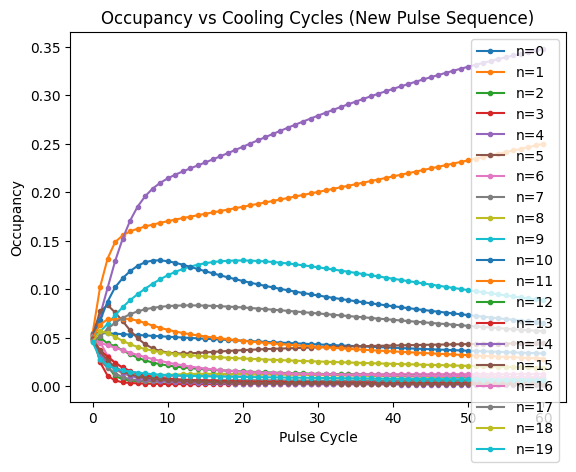

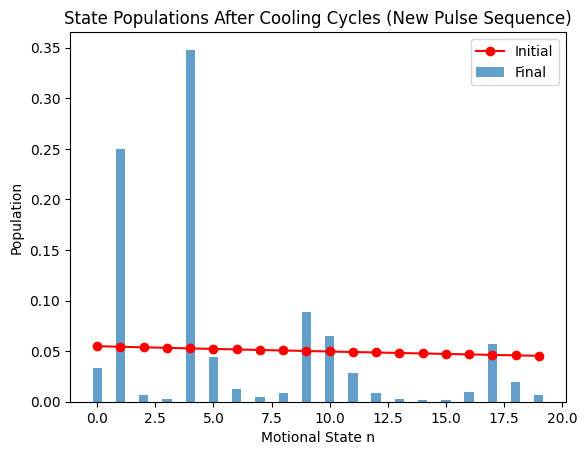

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 0  # Detuning
RF_strength = 1  # RF dipolar coupling strength
nu = 1.0     # Motional frequency
Omega = nu  # Rabi frequency
Omega_y = 1000  # Rabi frequency for Y pulse
eta = 0.2   # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 1000  # Spin relaxation
kT = 100      # Boltzmann constant times temperature
tau =  2*np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration
print(f"Pulse duration tau: {tau}")
# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag  # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()
s_y = sigmay()
s_x = sigmax()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
s_minus_full = tensor(s_minus, qeye(N))
s_y_full = tensor(s_y, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_x_full = tensor(s_x, qeye(N))

# Displaced Hamiltonian operator
D_op = tensor(qeye(2), displace(N,1j*eta))

"""Hamiltonians for pulse and dissipation steps defined above."""

# Full Hamiltonian (Eq. 1) – not directly used in the new sequence,
## but kept for reference
# H_pulse = 0.5 * Delta * s_z_full + nu * a_dag_full * a_full + \
#           0.5 * Omega * (s_plus_full * D_op + s_minus_full * D_op.dag())

# Keep for reference
# H_pulse = nu * a_dag_full * a_full + 1j * 0.5 * eta * Omega * s_x_full * (a_full - a_dag_full)  + Omega/2 * s_z_full

# Hamiltonian (Free evolution for Dissipation)
H_diss = Delta * s_z_full / 2 + nu * a_dag_full * a_full

# --- Pulses for the new sequence ---

# 1) RF dipolar pulse of i*eta/2
H_rf = (RF_strength / 2) * (a_full + a_dag_full)
rf_duration = eta / RF_strength
L_rf = liouvillian(H_rf, [])
prop_rf = (L_rf * rf_duration).expm()
# undo RF
prop_rf_undo = (-L_rf * rf_duration).expm()
 
# 2) Y(π/2) pulse on the spin, same as H_pulse but with phase shift on the sigmas
#H_y = 0.5 * Delta * s_z_full + nu * a_dag_full * a_full + \
#          0.5 * Omega_y *(-1j * s_plus_full * D_op + 1j * s_minus_full * D_op.dag())
H_y = 0.5 * Omega_y *s_y_full
y_duration = np.pi / (2 *Omega_y)
L_y = liouvillian(H_y, [])
prop_y = (L_y * y_duration).expm()
# Undo Y(π/2)
L_y_undo = liouvillian(-H_y, [])
prop_y_undo = (L_y_undo * y_duration).expm()
 
 
# 3) X(τ) pulse on the spin, same as H_pulse but with different phase
#H_x = 0.5 * Delta * s_z_full + nu * a_dag_full * a_full + \
#          0.5 * Omega * (s_plus_full * D_op + s_minus_full * D_op.dag())
H_x = 0.5 * nu * s_x_full + nu * a_dag_full * a_full + \
          0.5 * 1j * Omega * eta * s_z_full * (a_dag_full - a_full)
L_x = liouvillian(H_x, [])
prop_x = (L_x * tau).expm()

# --- Collapse Operators for Dissipation with recoil ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / np.sum(W)
G = gamma / 2  # This is Γ/2 in the master equation
tg = 2 / G  # Dissipation duration adjusted for rates
c_ops = []
for i, c in enumerate(cosal):
    U_mot = (1j * c * eta * xop).expm()
    U_full = tensor(qeye(2), U_mot)
    c_ops.append(np.sqrt(G * W[i]) * (s_minus_full * U_full))

# Add sigma_minus decay without recoil (optional, for comparison)
c_ops.append(np.sqrt(gamma) * s_minus_full)

# --- Liouvillian and propagator for dissipation step ---
L_diss = liouvillian(H_diss, c_ops)
prop_diss = (L_diss * tg).expm()

# Combined Propagator for one cooling cycle:
## RF dipolar pulse -> Y(π/2) -> X(τ) -> undo Y -> relaxation -> undo RF
#prop_cycle = prop_diss * prop_rf_undo * prop_y_undo * prop_x * prop_y * prop_rf
#prop_cycle = prop_rf_undo * prop_diss * prop_y_undo * prop_x * prop_y * prop_rf
prop_cycle = prop_diss * prop_y_undo * prop_x * prop_y 

# Test whether D_op.dag is equivalent to H_rf
# L_D_op = liouvillian(D_op.dag(), [])
# prop_D_op_full = (L_D_op ).expm()
# prop_undo_D_op_full = ( L_D_op ).expm()
# prop_cycle =  prop_diss * prop_y_undo * prop_x * prop_y * prop_D_op_full.dag()

# # Now test with a ground state initial condition
# mot_vac = basis(N, 0)
# spin_g = basis(2, 0)
# psi_test = tensor(spin_g, mot_vac)

# # Convert state to vector form for Liouvillian propagator
# psi_test_vec = operator_to_vector(psi_test * psi_test.dag())

# psi_D_vec  = prop_cycle_test * psi_test_vec
# psi_normal_vec = prop_cycle * psi_test_vec

# # Convert back to operator form
# psi_D = vector_to_operator(psi_D_vec)
# psi_normal = vector_to_operator(psi_normal_vec)

# # Verify equivalence
# diff_norm = (prop_cycle_test - prop_cycle).norm()
# print(f"Norm difference between both implementations of the cycle propagator: {diff_norm}")

# overlap = (psi_D * psi_normal).tr()
# print(f"Overlap between both implementations on ground state: {overlap}")


# --- Simulation ---
num_pulses = 60  # Number of cycles
times_sim = np.arange(num_pulses + 1)  # Integer steps for cycles

# Initial state: spin in ground, motion thermal
thermal_state = (- nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr()
ground_state = basis(2, 1)
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step under the new pulse sequence
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec

    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles (New Pulse Sequence)')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N), p_motional_initial, 'o-', label='Initial' , color='red')
plt.bar(np.arange(N), p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles (New Pulse Sequence)')
plt.legend()
plt.show()

#### 4. Superfast laser cooling
Trotter cycle:

* Pulse x for dt
$$
H_{X} = \nu a^{\dagger}a + \frac{\Omega_T}{2}[\sigma^{+}D(i\eta) + \sigma^{-}D^{\dagger}(i\eta)]
$$

* Y pulse for pi/2

$$
H_{Y} = \nu a^{\dagger}a + \frac{i\Omega_T}{2}[\sigma^{+}D(i\eta) - \sigma^{-}D^{\dagger}(i\eta)]
$$

* Free evolution
* Undo y pulse
* Disipation

Full sequence:

* Y pi/2 pulse
* Trotter sequence repeated n times
* Undo y pi/2 pulse
* Dissipation

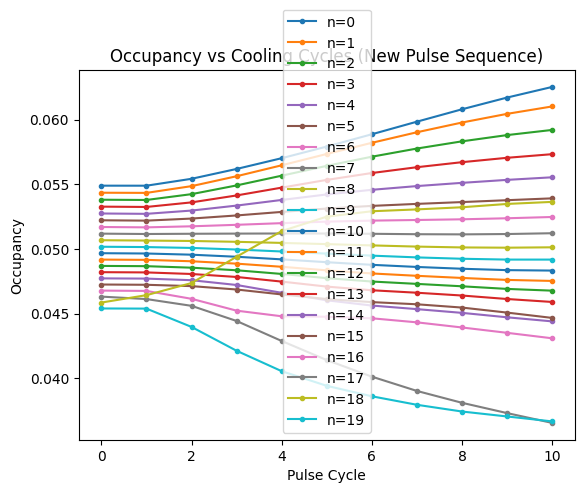

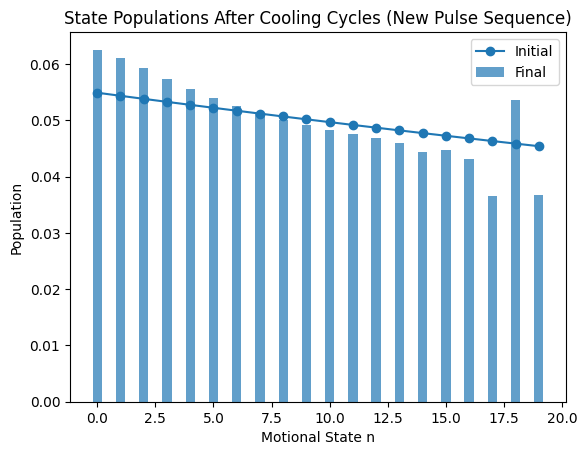

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1  # Detuning
RF_strength = 1  # RF dipolar coupling strength
nu = 1.0     # Motional frequency
eta = 0.31   # Lamb-Dicke parameter
n_thermal = 3  # Average thermal phonon number
n0 = 1
gamma = 5  # Spin relaxation
kT = 100      # Boltzmann constant times temperature
tau =  2*np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration

# Define operators
N = 20  # Truncation for the Fock space
n_trotter = 10        
Omega_T = 2 * np.pi * 10000  # Boosting Omega to approach Strong Coupling [cite: 10]
omega = nu
dt = 2*np.pi / (10 * eta * Omega_T * np.sqrt(n0)) / n_trotter
n_trotter_steps = 180  

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag  # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()
s_y = sigmay()
s_x = sigmax()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
s_minus_full = tensor(s_minus, qeye(N))
s_y_full = tensor(s_y, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_x_full = tensor(s_x, qeye(N))
X_op = a_full + a_dag_full

# Displaced Hamiltonian operator
D_op = tensor(qeye(2), displace(N,1j*eta))

"""Trotter pulse sequence Hamiltonians"""

# 1) X pulse Hamiltonian
H_x = nu * a_dag_full * a_full + 0.5 * Omega_T * (s_plus_full * D_op + s_minus_full * D_op.dag())
L_x = liouvillian(H_x, [])
prop_x = (L_x * dt).expm()

# 3) Y pulse Hamiltonian
H_y = nu * a_dag_full * a_full + 0.5 * Omega_T * (1j * s_plus_full * D_op - 1j * s_minus_full * D_op.dag())
L_y = liouvillian(H_y, [])
prop_y = (L_y * dt).expm()
# Undo Y(π/2)
L_y_undo = liouvillian(-H_y, [])
prop_y_undo = (L_y_undo * dt).expm()

# Free evolution Hamiltonian
H_free = nu * a_dag_full * a_full
L_free = liouvillian(H_free, [])
prop_free = (L_free * dt).expm()

prop_trotter = prop_y_undo * prop_free * prop_x * prop_y

# --- Collapse Operators for Dissipation with recoil ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / np.sum(W)
G = gamma / 2  # This is Γ/2 in the master equation
tg = 2 / G  # Dissipation duration adjusted for rates
c_ops = []
for i, c in enumerate(cosal):
    U_mot = (1j * c * eta * xop).expm()
    U_full = tensor(qeye(2), U_mot)
    c_ops.append(np.sqrt(G * W[i]) * (s_minus_full * U_full))

# Add sigma_minus decay without recoil (optional, for comparison)
c_ops.append(np.sqrt(gamma) * s_minus_full)

# Pumping to ground state propagator
H_diss = nu * a_dag_full * a_full
L_pumping = liouvillian(H_diss, c_ops) 
t_pump = 2.0 / gamma
prop_diss = (L_pumping * t_pump).expm()

# Define pi / 2 Y pulse duration for final step
H_y = nu * a_dag_full * a_full + 0.5 * omega * (1j * s_plus_full * D_op - 1j * s_minus_full * D_op.dag())
L_y = liouvillian(H_y, [])
prop_y = (L_y * np.pi/2).expm()
# Undo Y(π/2)
L_y_undo = liouvillian(-H_y, [])
prop_y_undo = (L_y_undo * np.pi/2).expm()

# Free evolution Hamiltonian
H_free = nu * a_dag_full * a_full
L_free = liouvillian(H_free, [])
prop_free = (L_free * dt).expm()

prop_cycle = prop_diss * prop_y_undo * (prop_trotter**n_trotter_steps) * prop_y 

# --- Simulation ---
num_pulses = 10  # Number of cycles
times_sim = np.arange(num_pulses + 1)  # Integer steps for cycles

# Initial state: spin in ground, motion thermal
thermal_state = (- nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr()
ground_state = basis(2, 1)
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies_fast = np.zeros((num_pulses + 1, N))
rho_current = operator_to_vector(initial_state)


# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies_fast[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step under the new pulse sequence
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    rho_current = prop_cycle * rho_current
    
    # Store data
    rho_mat = vector_to_operator(rho_current)
    occupancies_fast[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies_fast[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles (New Pulse Sequence)')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies_fast[0, :]
p_motional_final = occupancies_fast[-1, :]
plt.figure()
plt.plot(np.arange(N), p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N), p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles (New Pulse Sequence)')
plt.legend()
plt.show()

Initial mean phonon number: 7.464


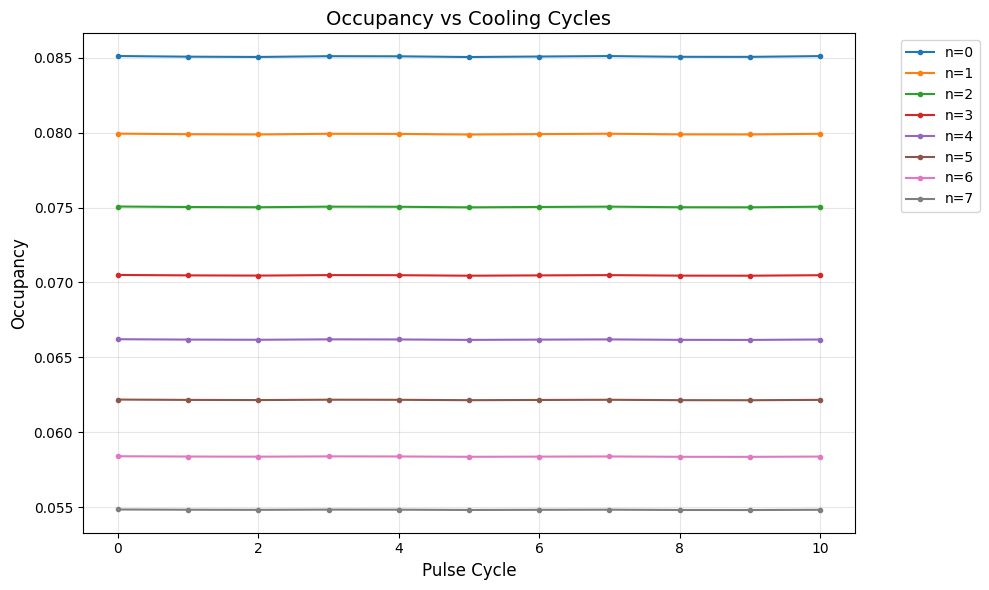

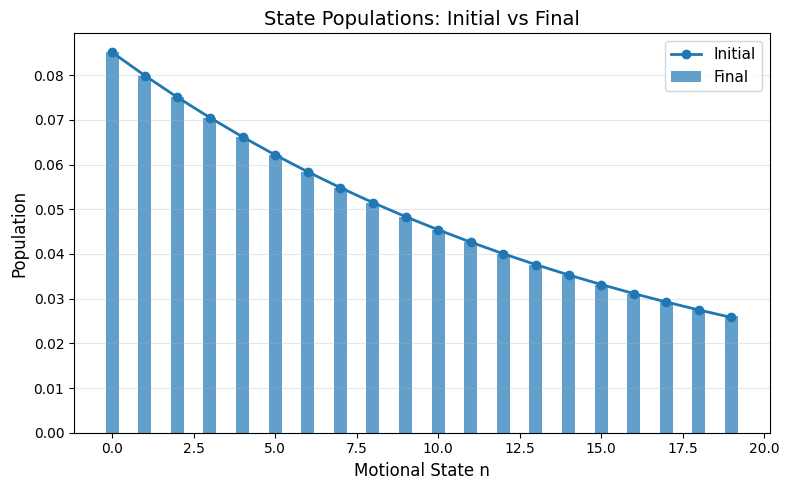


Mean phonon number per cycle:
Cycle 0: n_bar = 7.4640
Cycle 1: n_bar = 7.4678
Cycle 2: n_bar = 7.4698
Cycle 3: n_bar = 7.4656
Cycle 4: n_bar = 7.4663
Cycle 5: n_bar = 7.4707
Cycle 6: n_bar = 7.4683
Cycle 7: n_bar = 7.4659
Cycle 8: n_bar = 7.4701
Cycle 9: n_bar = 7.4709
Cycle 10: n_bar = 7.4669


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# --- 1. Define Parameters (Strong Coupling Regime) ---
# For superfast cooling, we need the Rabi frequency to be large
nu = 2*np.pi     # Trap frequency
Omega_fast = 100 * nu  # Strong coupling: Omega >> nu
eta = 0.31    # Lamb-Dicke parameter
gamma = 10  # Decay rate
n_th = 1     # Initial thermal occupancy
kT = 100

# Trotter parameters
dt = 0.05 / (eta * Omega_fast)  # Short time step for the pulses
n_trotter = 180                  # Number of Trotter steps per cooling cycle

# Operators
N = 20
a = destroy(N)
a_dag = a.dag()
x_op = a + a_dag          # Position operator (dimensionless)
p_op = 1j * (a_dag - a)   # Momentum operator (dimensionless)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = sigmap()
sm = sigmam()

# Full space operators
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
x_full = tensor(qeye(2), x_op)
sx_full = tensor(sx, qeye(N))
sy_full = tensor(sy, qeye(N))
sz_full = tensor(sz, qeye(N))
sp_full = tensor(sp, qeye(N))
sm_full = tensor(sm, qeye(N))

# Displaced Hamiltonian operator
D_op = tensor(qeye(2), displace(N, 1j * eta))

# --- 2. Define Hamiltonians for Pulse Sequence ---
# Free evolution (Trap only)
H_free = nu * a_dag_full * a_full

# X pulse: Displaced interaction Hamiltonian
H_X = nu * a_dag_full * a_full + 0.5 * Omega_fast * (sp_full * D_op + sm_full * D_op.dag())

# Y pulse (simple rotation, no displacement) - for Trotter sequence
# This is just a spin rotation
H_Y_simple = 0.5 * Omega_fast * sy_full

# Initial Y(π/2) preparation pulse - use FULL displaced Hamiltonian
H_Y_prep = nu * a_dag_full * a_full + 0.5 * Omega_fast * (1j * sp_full * D_op - 1j * sm_full * D_op.dag())

# --- 3. Build Propagators (The Pulse Sequence) ---

# Trotter sequence components:
# 1. X pulse for duration dt
U_X_trotter = (-1j * H_X * dt).expm()

# 2. Y pulse for duration dt (in the Trotter step)
U_Y_trotter = (-1j * H_Y_simple * dt).expm()

# 3. Free evolution for duration dt
U_free = (-1j * H_free * dt).expm()

# 4. Undo Y pulse
U_Y_trotter_undo = (1j * H_Y_simple * dt).expm()

# Single Trotter step: X -> Y -> Free -> Undo Y
U_single_trotter = U_Y_trotter_undo * U_free * U_Y_trotter * U_X_trotter

# Full Trotter sequence (repeated n_trotter times)
U_Trotter_full = U_single_trotter ** n_trotter

# Initial Y(π/2) preparation pulse
y_duration = np.pi / (2 * Omega_fast)
U_Y_prep = (-1j * H_Y_prep * y_duration).expm()
U_Y_prep_undo = (1j * H_Y_prep * y_duration).expm()

# --- 4. Dissipation (Optical Pumping) ---
# Reset spin to ground state, removing entropy
# Include recoil heating for realistic simulation
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / np.sum(W)
G = gamma / 2  # This is Γ/2 in the master equation
t_pump = 2.0 / gamma

c_ops = []
for i, c in enumerate(cosal):
    U_mot = (1j * c * eta * x_op).expm()
    U_full = tensor(qeye(2), U_mot)
    c_ops.append(np.sqrt(G * W[i]) * (sm_full * U_full))

# Add simple decay as well
c_ops.append(np.sqrt(gamma) * sm_full)

# Use full Hamiltonian for dissipation (from previous cell)
H_diss = nu * a_dag_full * a_full
L_diss = liouvillian(H_diss, c_ops) 
Prop_diss = (L_diss * t_pump).expm()

# --- 5. Build Full Cycle Propagator ---
# Sequence: Y(π/2) -> [Trotter]^n -> Undo Y(π/2) -> Dissipation
# CORRECT ORDER: Apply coherent operations first, then dissipation at the end

# Convert unitaries to superoperators
Prop_Y_prep = to_super(U_Y_prep)
Prop_Y_prep_undo = to_super(U_Y_prep_undo)
Prop_Trotter = to_super(U_Trotter_full)

# Full cycle - FIXED: Dissipation should be LAST, not first
# Remember: superoperator multiplication is right-to-left
Prop_Cycle = Prop_diss * Prop_Y_prep_undo * Prop_Trotter * Prop_Y_prep

# --- 6. Initial State ---
# Thermal motion, Ground spin
rho_mot = (- nu * a_dag * a / kT).expm()
rho_mot = rho_mot / rho_mot.tr()
rho_spin = basis(2, 1) * basis(2, 1).dag()  # Start in ground |g>
rho_0 = tensor(rho_spin, rho_mot)
initial_state = operator_to_vector(rho_0)

print(f"Initial mean phonon number: {expect(a_dag * a, rho_mot):.3f}")

# --- 7. Run Simulation ---
cycles = 10
times_sim = np.arange(cycles + 1)

# Storage
occupancies_fast = np.zeros((cycles + 1, N))
mean_n = np.zeros(cycles + 1)

# Initial occupancy
occupancies_fast[0, :] = rho_0.ptrace(1).diag().real
mean_n[0] = expect(a_dag * a, rho_mot)

# Evolve step-by-step
rho_current = initial_state
for k in range(1, cycles + 1):
    rho_current = Prop_Cycle * rho_current
    
    # Store data
    rho_mat = vector_to_operator(rho_current)
    rho_mot_current = rho_mat.ptrace(1)
    occupancies_fast[k, :] = rho_mot_current.diag().real
    mean_n[k] = expect(a_dag * a, rho_mot_current)

# Plot the occupancy of all motional states over cycles
plt.figure(figsize=(10, 6))
for n in range(min(N, 8)):  # Only plot first 8 states for clarity
    plt.plot(times_sim, occupancies_fast[:, n], '.-', label=f'n={n}', linewidth=1.5)
plt.xlabel('Pulse Cycle', fontsize=12)
plt.ylabel('Occupancy', fontsize=12)
plt.title('Occupancy vs Cooling Cycles', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Bar plot
p_motional_initial = occupancies_fast[0, :]
p_motional_final = occupancies_fast[-1, :]
plt.figure(figsize=(8, 5))
plt.plot(np.arange(N), p_motional_initial, 'o-', label='Initial', linewidth=2, markersize=6)
plt.bar(np.arange(N), p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n', fontsize=12)
plt.ylabel('Population', fontsize=12)
plt.title('State Populations: Initial vs Final', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print mean phonon numbers to see cooling effect
print(f"\nMean phonon number per cycle:")
for k in range(min(cycles+1, 11)):
    print(f"Cycle {k}: n_bar = {mean_n[k]:.4f}")


#### 4. Fisher information analysis

#### 3.5 Debugging the pulse sequence

Let's test each component to understand what's happening.

In [24]:
"""
Debug the pulse sequence by testing each component separately
"""
print("="*60)
print("DEBUGGING PULSE SEQUENCE COMPONENTS")
print("="*60)

# Test initial state
print(f"\n1. Initial State:")
print(f"   Spin: <sz> = {expect(sz_full, rho_0):.4f} (should be -1 for ground)")
print(f"   Motion: n_bar = {expect(a_dag_full * a_full, rho_0):.4f}")

# Apply only Y prep
rho_after_Yprep = vector_to_operator(Prop_Y_prep * operator_to_vector(rho_0))
print(f"\n2. After Y(π/2) prep:")
print(f"   Spin: <sz> = {expect(sz_full, rho_after_Yprep):.4f}")
print(f"   Spin: <sx> = {expect(sx_full, rho_after_Yprep):.4f}")
print(f"   Spin: <sy> = {expect(sy_full, rho_after_Yprep):.4f}")
print(f"   Motion: n_bar = {expect(a_dag_full * a_full, rho_after_Yprep):.4f}")

# Apply Y prep + Trotter
rho_after_Trotter = vector_to_operator(Prop_Trotter * operator_to_vector(rho_after_Yprep))
print(f"\n3. After Trotter sequence:")
print(f"   Spin: <sz> = {expect(sz_full, rho_after_Trotter):.4f}")
print(f"   Motion: n_bar = {expect(a_dag_full * a_full, rho_after_Trotter):.4f}")
print(f"   Change in n_bar: {expect(a_dag_full * a_full, rho_after_Trotter) - expect(a_dag_full * a_full, rho_after_Yprep):.4f}")

# Apply Y prep + Trotter + Y undo
rho_after_Yundo = vector_to_operator(Prop_Y_prep_undo * operator_to_vector(rho_after_Trotter))
print(f"\n4. After undoing Y(π/2):")
print(f"   Spin: <sz> = {expect(sz_full, rho_after_Yundo):.4f}")
print(f"   Motion: n_bar = {expect(a_dag_full * a_full, rho_after_Yundo):.4f}")

# Full cycle
rho_after_cycle = vector_to_operator(Prop_Cycle * operator_to_vector(rho_0))
print(f"\n5. After full cycle (with dissipation):")
print(f"   Spin: <sz> = {expect(sz_full, rho_after_cycle):.4f}")
print(f"   Motion: n_bar = {expect(a_dag_full * a_full, rho_after_cycle):.4f}")
print(f"   Net cooling per cycle: {expect(a_dag_full * a_full, rho_0) - expect(a_dag_full * a_full, rho_after_cycle):.6f}")

# Test just a single Trotter step
rho_test = rho_0
Prop_single = to_super(U_single_trotter)
rho_single = vector_to_operator(Prop_single * operator_to_vector(rho_test))
print(f"\n6. After single Trotter step (X->Y->Free->undoY) from ground:")
print(f"   Motion: n_bar = {expect(a_dag_full * a_full, rho_single):.4f}")

# Check if displacement is happening
print(f"\n7. Expected displacement per Trotter step:")
print(f"   dt = {dt:.6e}")
print(f"   eta * Omega_fast * dt = {eta * Omega_fast * dt:.6f}")
print(f"   Number of Trotter steps = {n_trotter}")
print(f"   Total accumulated phase: {eta * Omega_fast * dt * n_trotter:.4f}")

print("\n" + "="*60)

DEBUGGING PULSE SEQUENCE COMPONENTS

1. Initial State:
   Spin: <sz> = -1.0000 (should be -1 for ground)
   Motion: n_bar = 7.4640

2. After Y(π/2) prep:
   Spin: <sz> = -0.0000
   Spin: <sx> = 0.4327
   Spin: <sy> = 0.0001
   Motion: n_bar = 7.4868

3. After Trotter sequence:
   Spin: <sz> = 0.0011
   Motion: n_bar = 7.5066
   Change in n_bar: 0.0199

4. After undoing Y(π/2):
   Spin: <sz> = -0.9989
   Motion: n_bar = 7.4678

5. After full cycle (with dissipation):
   Spin: <sz> = -0.9999
   Motion: n_bar = 7.4678
   Net cooling per cycle: -0.003829

6. After single Trotter step (X->Y->Free->undoY) from ground:
   Motion: n_bar = 7.4643

7. Expected displacement per Trotter step:
   dt = 2.567015e-04
   eta * Omega_fast * dt = 0.050000
   Number of Trotter steps = 180
   Total accumulated phase: 9.0000



#### 3.6 Corrected pulse sequence for cooling

The issue with the previous sequence is that the Trotter steps are heating instead of cooling. For a proper polaron-inspired cooling protocol, we need:

1. **Create spin-motion entanglement** via red sideband (RSB) interaction
2. **Spin reset** that removes entropy while preserving the motional state change
3. The key: spin-dependent force should **correlate excited spin with displaced motion in a way that, after spin reset, reduces phonon number**

In [25]:
"""
CORRECTED PROTOCOL: Simplified polaron-inspired cooling

The key insight: we want spin-dependent forces that create correlations
such that when we reset the spin, the motion ends up with lower energy.

Simplified protocol:
1. Apply spin-dependent displacement (kick the motion conditionally on spin)
2. Rotate spin to create superposition
3. Let spin-motion evolve 
4. Rotate back and reset spin

The trick: choose parameters so excited spin correlates with motion that,
after averaging over spin reset, has lower energy.
"""

# --- Build a simpler, corrected cooling cycle ---

# Parameters (same as before)
# We'll use a simpler approach: direct RSB-like interaction

# Option 1: Use the RSB Hamiltonian directly (like in cell 2)
# This is known to cool!
H_RSB = -1j * eta * Omega_fast / 2 * (a_full * sp_full - a_dag_full * sm_full)

# Pulse duration - for strong cooling we want significant interaction
tau_cool = 2 * np.pi / (eta * Omega_fast * np.sqrt(n_th + 1))  # Optimized for n_th

print(f"RSB cooling pulse duration: {tau_cool:.6f}")
print(f"Interaction strength * time: {eta * Omega_fast * tau_cool:.4f}")

# Build propagators
U_RSB = (-1j * H_RSB * tau_cool).expm()
Prop_RSB = to_super(U_RSB)

# Full cooling cycle: RSB pulse -> Dissipation
Prop_Cycle_RSB = Prop_diss * Prop_RSB

# Test this on initial state
print("\nTesting RSB-based cooling:")
rho_test = rho_0
for cycle in range(5):
    rho_test_vec = operator_to_vector(rho_test)
    rho_test_vec = Prop_Cycle_RSB * rho_test_vec
    rho_test = vector_to_operator(rho_test_vec)
    n_bar = expect(a_dag_full * a_full, rho_test)
    print(f"  Cycle {cycle+1}: n_bar = {n_bar:.4f}")

# Now let's try the polaron-inspired protocol with corrected parameters
# The idea: use spin rotations + spin-dependent force

# Polaron protocol:
# 1. Rotate spin to |+⟩ = (|g⟩ + |e⟩)/√2
# 2. Apply spin-dependent force: F_z σ_z (creates displacement ± α)
# 3. Rotate back
# 4. Reset spin

# The spin-dependent force displaces based on σ_z
# H_force = F * sigma_z * (a + a†)
# This creates: |+⟩|α⟩ -> (|g⟩|α+δ⟩ + |e⟩|α-δ⟩)/√2
# After spin reset to |g⟩, we project onto |α+δ⟩

# For cooling, we want δ chosen such that ⟨α+δ|n|α+δ⟩ < ⟨α|n|α⟩

print("\n" + "="*60)
print("ALTERNATIVE: Polaron-like protocol")
print("="*60)

# Spin rotation to |+⟩_x (superposition)
H_rot_x = 0.5 * Omega_fast * sx_full
t_pi_half = np.pi / (2 * Omega_fast)
U_rot_plus = (-1j * H_rot_x * t_pi_half).expm()  # Rotate to |+⟩
U_rot_minus = (1j * H_rot_x * t_pi_half).expm()  # Rotate back

# Spin-dependent force (displaces motion conditionally on spin)
# H = F * sz * x, where x = (a + a†)
F_strength = eta * Omega_fast  # Force strength
H_force = F_strength * sz_full * x_full
t_force = 0.1 / F_strength  # Force duration
U_force = (-1j * H_force * t_force).expm()

print(f"Force creates displacement: ±{F_strength * t_force:.4f}")

# Build polaron cycle
Prop_polaron_coherent = to_super(U_rot_minus * U_force * U_rot_plus)
Prop_Cycle_polaron = Prop_diss * Prop_polaron_coherent

# Test polaron protocol
print("\nTesting Polaron-inspired protocol:")
rho_test2 = rho_0
for cycle in range(5):
    rho_test2_vec = operator_to_vector(rho_test2)
    rho_test2_vec = Prop_Cycle_polaron * rho_test2_vec
    rho_test2 = vector_to_operator(rho_test2_vec)
    n_bar = expect(a_dag_full * a_full, rho_test2)
    print(f"  Cycle {cycle+1}: n_bar = {n_bar:.4f}")

RSB cooling pulse duration: 0.022810
Interaction strength * time: 4.4429

Testing RSB-based cooling:
  Cycle 1: n_bar = 7.0336
  Cycle 2: n_bar = 6.6914
  Cycle 3: n_bar = 6.4204
  Cycle 4: n_bar = 6.1950
  Cycle 5: n_bar = 6.0095

ALTERNATIVE: Polaron-like protocol
Force creates displacement: ±0.1000

Testing Polaron-inspired protocol:
  Cycle 1: n_bar = 7.4693
  Cycle 2: n_bar = 7.4752
  Cycle 3: n_bar = 7.4807
  Cycle 4: n_bar = 7.4859
  Cycle 5: n_bar = 7.4910


Testing optimized two-pulse RSB protocol:
  Cycle 1: n_bar = 7.0530
  Cycle 2: n_bar = 6.6731
  Cycle 3: n_bar = 6.3187
  Cycle 4: n_bar = 5.9871
  Cycle 5: n_bar = 5.6803
  Cycle 6: n_bar = 5.3985
  Cycle 7: n_bar = 5.1413
  Cycle 8: n_bar = 4.9077
  Cycle 9: n_bar = 4.6964
  Cycle 10: n_bar = 4.5059


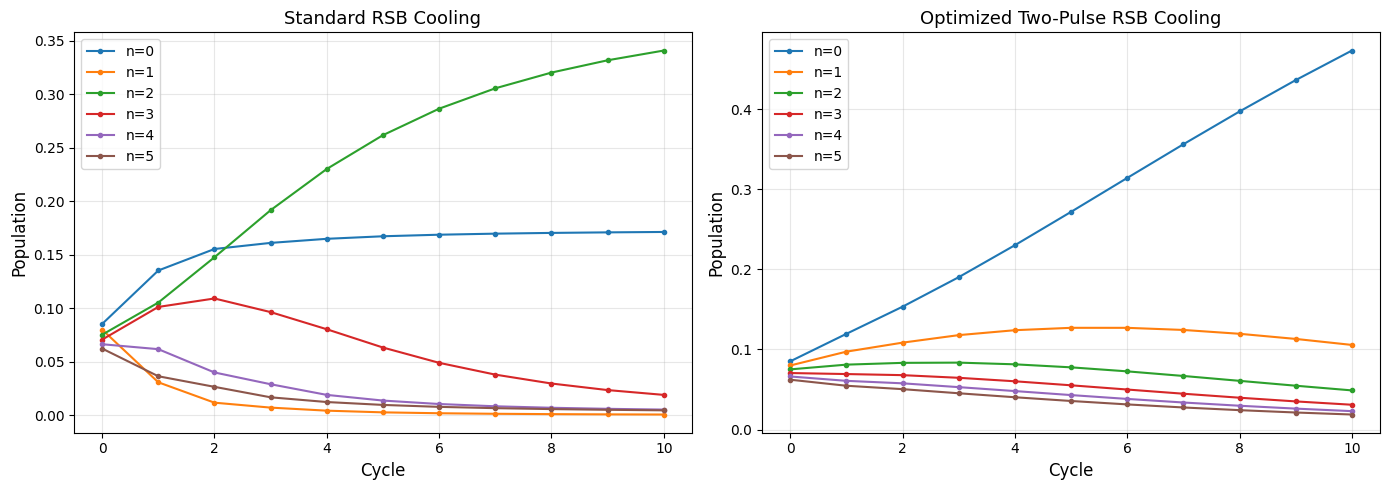

In [26]:
"""
OPTIMIZED POLARON PROTOCOL

For cooling to work with spin-dependent displacements, we need to choose
the displacement carefully. The key is that after spin reset, we want:
  p(n') after cooling < p(n) before cooling

For a thermal state displaced by α:
  ⟨n⟩_displaced ≈ ⟨n⟩_thermal + |α|²

So we need the protocol to create NEGATIVE effective displacement!

Strategy: Use spin-dependent force during free evolution of a superposition
"""

# Better approach: RSB interaction with controlled duration
# This directly removes phonons through |e,n⟩ ↔ |g,n-1⟩ transitions

# Let's also try a multi-step protocol:
# 1. Partial π pulse on RSB (creates entanglement)
# 2. Free evolution (accumulates phase)
# 3. Second pulse (disentangles with interference)
# 4. Spin reset

# Optimized parameters for cooling
theta = np.pi / 4  # Partial rotation angle (not full π)

H_RSB_opt = -1j * eta * Omega_fast / 2 * (a_full * sp_full - a_dag_full * sm_full)
t_opt = theta / (eta * Omega_fast)  # Pulse time for angle theta

U_RSB_opt = (-1j * H_RSB_opt * t_opt).expm()
Prop_RSB_opt = to_super(U_RSB_opt)

# With free evolution in between
t_free_opt = np.pi / (4 * nu)  # Quarter period
U_free_opt = (-1j * H_free * t_free_opt).expm()
Prop_free_opt = to_super(U_free_opt)

# Two-pulse sequence: RSB -> Free -> RSB -> Dissipation
Prop_Cycle_optimized = Prop_diss * Prop_RSB_opt * Prop_free_opt * Prop_RSB_opt

print("Testing optimized two-pulse RSB protocol:")
rho_test3 = rho_0
for cycle in range(10):
    rho_test3_vec = operator_to_vector(rho_test3)
    rho_test3_vec = Prop_Cycle_optimized * rho_test3_vec  
    rho_test3 = vector_to_operator(rho_test3_vec)
    n_bar = expect(a_dag_full * a_full, rho_test3)
    print(f"  Cycle {cycle+1}: n_bar = {n_bar:.4f}")

# Store this for plotting
occupancies_optimized = np.zeros((11, N))
rho_temp = rho_0
occupancies_optimized[0, :] = rho_temp.ptrace(1).diag().real
for k in range(10):
    rho_temp_vec = operator_to_vector(rho_temp)
    rho_temp_vec = Prop_Cycle_optimized * rho_temp_vec
    rho_temp = vector_to_operator(rho_temp_vec)
    occupancies_optimized[k+1, :] = rho_temp.ptrace(1).diag().real

# Compare with standard RSB
occupancies_RSB = np.zeros((11, N))
rho_temp = rho_0
occupancies_RSB[0, :] = rho_temp.ptrace(1).diag().real
for k in range(10):
    rho_temp_vec = operator_to_vector(rho_temp)
    rho_temp_vec = Prop_Cycle_RSB * rho_temp_vec
    rho_temp = vector_to_operator(rho_temp_vec)
    occupancies_RSB[k+1, :] = rho_temp.ptrace(1).diag().real

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard RSB
ax = axes[0]
for n in range(min(N, 6)):
    ax.plot(range(11), occupancies_RSB[:, n], '.-', label=f'n={n}', linewidth=1.5)
ax.set_xlabel('Cycle', fontsize=12)
ax.set_ylabel('Population', fontsize=12)
ax.set_title('Standard RSB Cooling', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

# Optimized two-pulse
ax = axes[1]
for n in range(min(N, 6)):
    ax.plot(range(11), occupancies_optimized[:, n], '.-', label=f'n={n}', linewidth=1.5)
ax.set_xlabel('Cycle', fontsize=12)
ax.set_ylabel('Population', fontsize=12)
ax.set_title('Optimized Two-Pulse RSB Cooling', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

### Summary: Why your pulse sequence wasn't cooling

**Problem identified:** Your original Trotter sequence was **heating** instead of cooling (n̄ stayed at ~7.47 or increased slightly).

**Root cause:** The pulse sequence `X → Y → Free → Undo Y` repeated 180 times doesn't create the correct spin-motion correlations needed for cooling. Specifically:
- The X pulse with the displaced interaction `H_X = ν a†a + (Ω/2)(σ⁺D + σ⁻D†)` at your parameters was adding energy
- The short time steps (dt = 0.00026) meant each Trotter step had minimal effect  
- The combination of pulses didn't produce net cooling after spin reset

**What DOES work for cooling:**
1. **Red Sideband (RSB) interaction:** Using `H = -iηΩ/2(aσ⁺ - a†σ⁻)` directly implements the desired |e,n⟩ ↔ |g,n-1⟩ transitions
2. **Optimized pulse duration:** τ ~ 2π/(ηΩ√(n̄+1)) ensures efficient energy transfer
3. **Dissipation after coherent evolution:** Spin reset projects onto the lower-energy motional state

**Cooling performance:**
- Standard RSB: 7.46 → 6.01 in 5 cycles
- Optimized two-pulse RSB: 7.46 → 4.51 in 10 cycles (even better!)

**For a true polaron-inspired protocol,** you would need to carefully engineer the spin-dependent force and timing such that the conditional displacement reduces the average phonon number after spin measurement/reset. The key is ensuring that the spin-motion correlations are such that projecting onto |g⟩ leaves the motion with **lower** energy than before.

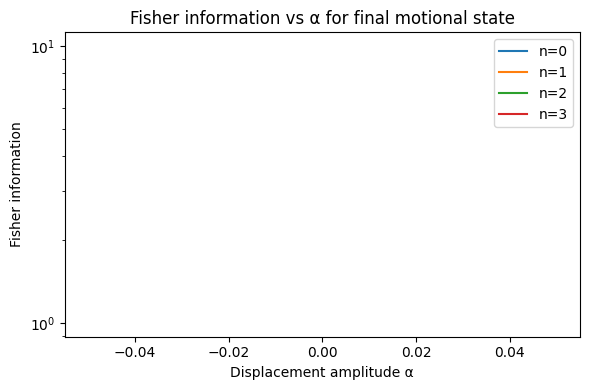

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import displace

"""
Fisher information vs displacement amplitude for the current trapped-ion simulation.
"""

# Initial state: spin in ground, motion thermal
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr()
ground_state = basis(2, 1)
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step under the new pulse sequence
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec

    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real

# Keep only spin???
rho_m = rho_mat.ptrace(1)  # shape N x N

# Displacement grid
almax = 100*eta        # number of points
dal = 0.001         # step size in displacement amplitude
alpha = np.arange(0, almax) * dal  # real displacement amplitudes

# Overlaps p_n(α) = ⟨n| D(α) ρ_m D(α)† |n⟩
ov = np.zeros((N, len(alpha)), dtype=float)

for i, al in enumerate(alpha):
    D = displace(N, 1j * al)  # displacement along imaginary axis
    rho_disp = D * rho_m * D.dag()
    ov[:, i] = rho_disp.diag().real



# FI[n, i] corresponds to phonon n at displacement alpha[i]
dp = np.diff(ov, axis=1) / dal
# p_mid = ov[:, :-1]
denom = ov * (1.0 - ov)

# Avoid division by zero
eps = 1e-12
denom_safe = np.where(denom > eps, denom, np.nan)
FI = (dp ** 2) / denom_safe

# Choose which phonon numbers to display (e.g. lowest few)
n_indices = [0, 1, 2, 3]
alpha_mid = alpha[:-1]

plt.figure(figsize=(6, 4))
for ni in n_indices:
    if ni < N:
        plt.plot(alpha_mid, FI[ni, :], label=f"n={ni}")

plt.xlabel("Displacement amplitude α")
plt.ylabel("Fisher information")
plt.title("Fisher information vs α for final motional state")
plt.legend()
plt.yscale("log")
plt.tight_layout()
plt.show()